# KT-15 Calibration Dependence on Housing Temperature

Whenever we do a calibration, we find that the KT15 over-estimates cold temperatures and under-estimates warm temperatures (see the blue dots above the orange line at low temps, but blue dots below the orange line at high temps):

![alt](KT15_Calibration_2020-10-30_7417_7409.png)

There is thus always a point somewhere in the middle of the calibration line where the KT15 measurement equals the blackbody temperature exactly. It appears that this "neutral calibration point" (aka the temperature at which applying the calibration has no effect) is related to the housing temperature:

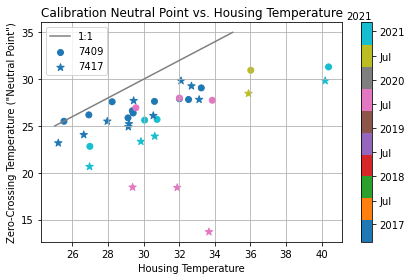

In [172]:
#create fake data array to apply the calibration to
data = np.linspace(0,40, 1000)

zero_crosses_7409 = []
for num in np.arange(0,len(cals_7409)):
    cal = cals_7409.iloc[num]
    calibrated = cal.slope*data + cal.yint
    diff = calibrated-data
    zero_cross_ind = np.where(np.diff(np.sign(diff)))[0]
    zero_crossing = data[zero_cross_ind]
    zero_crosses_7409.append(zero_crossing)
cals_7409['zero_crossing'] = zero_crosses_7409


zero_crosses_7417 = []
for num in np.arange(0,len(cals_7417)):
    cal = cals_7417.iloc[num]
    calibrated = cal.slope*data + cal.yint
    diff = calibrated-data
    zero_cross_ind = np.where(np.diff(np.sign(diff)))[0]
    zero_crossing = data[zero_cross_ind]
    zero_crosses_7417.append(zero_crossing)
cals_7417['zero_crossing'] = zero_crosses_7417

fig, axx = plt.subplots()
plt.scatter(cals_7409.housing, cals_7409.zero_crossing, c=mdates.date2num(cals_7409.index), cmap='tab10')
plt.scatter(cals_7417.housing, cals_7417.zero_crossing, c=mdates.date2num(cals_7417.index), cmap='tab10', marker='*', s=60)
plt.plot([25,35],[25,35],'gray')

plt.grid()
plt.legend(['1:1','7409', '7417'])
cb = plt.colorbar()
loc = mdates.AutoDateLocator()
cb.ax.yaxis.set_major_locator(loc)
cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))

plt.xlabel('Housing Temperature')
plt.ylabel('Zero-Crossing Temperature ("Neutral Point")')
plt.title('Calibration Neutral Point vs. Housing Temperature')

plt.tight_layout()

This relationship suggests that it is inappropriate to apply a calibration done at a certain housing temperature to a dataset taken at a different housing temperature. Applying a 25-degree calibration to a 35-degree dataset could easily lead us to overestimate the temperature by 0.5-1 degree! Looking at the housing temperatures on DYNAMO, it's clear that most of our calibrations aren't applicable:

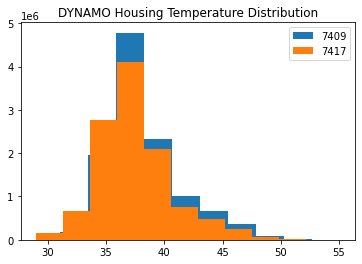

In [171]:
plt.hist(kt_dynamo.SeaRef) #7409
plt.hist(kt_dynamo.SkyRef) #7417
plt.legend(['7409','7417'])
plt.title('DYNAMO Housing Temperature Distribution');

Since the distribution of housing temperatures is centered near 36 degrees, I then tried calibrating our dataset just with the two calibrations centered on 36 and 40 degrees (July 2020 and March 2021, respectively). This leads to significant improvement in the agreement between sea snake and KT15 measurements:

Text(0.5, 1.0, 'Sea Snake vs. KT15 for all Dynamo Data')

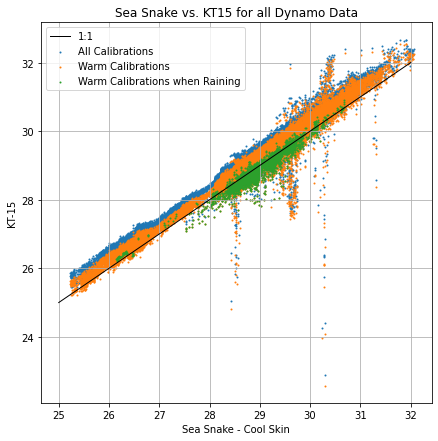

In [37]:
fig,axx = plt.subplots(figsize=(7,7))


sst_old = kt_1m.interp_like(rv)
sst_warmCal = kt_warm.interp_like(rv)
plt.scatter(rv.SST, sst_old, s=1, c='C0')
plt.scatter(rv.SST, sst_warmCal, s=1, c='C1')
plt.scatter(rv.SST, sst_warmCal.where(rv.P > 0.5), s=1, c='C2')
    
plt.plot(np.arange(25,33),np.arange(25,33),'k',linewidth=1)
plt.grid()
plt.xlabel('Sea Snake - Cool Skin')
plt.ylabel('KT-15')
plt.legend(['1:1','All Calibrations','Warm Calibrations','Warm Calibrations when Raining'],loc='upper left')

plt.title('Sea Snake vs. KT15 for all Dynamo Data')

Finally, I also wanted to try just sky-correcting the data without applying a lab calibration for comparison. We can see that applying the **right** calibration does seem to improve agreement compared to not calibrating at all:

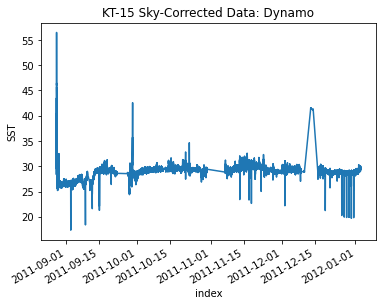

In [40]:
%autoreload
from KT15_Toolbox import KT15_skycorrect82

KT15_skycorrect82(l1data_path = '../Data/Level_1/Dynamo/KT15/Dynamo_KT15_7409_7417.cdf',
                  output_path = '../Data/Level_3/Dynamo/KT15/')

#New version using sky correction but no calibration
kt_noCaldynamo = xr.open_dataset('../Data/Level_3/Dynamo/KT15/Dynamo_KT15_SkyCorrectedSST_only.cdf')
#sort dataset into sequential timesteps
kt_noCaldynamo = kt_noCaldynamo.sortby(kt_noCaldynamo.index)

kt_none = kt_noCaldynamo.interp_like(rv)

Text(0.5, 1.0, 'Sea Snake vs. KT15 for all Dynamo Data')

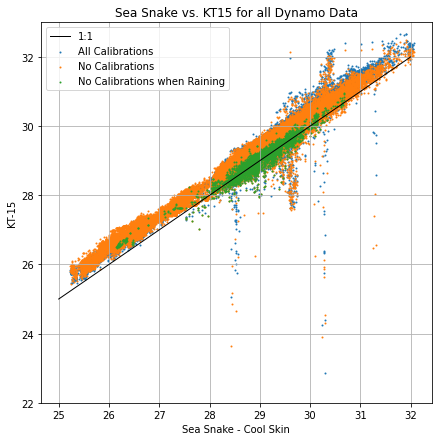

In [44]:
fig,axx = plt.subplots(figsize=(7,7))

sst_old = kt_1m.interp_like(rv)

plt.scatter(rv.SST, sst_old, s=1, c='C0')
plt.scatter(rv.SST, kt_none.SST, s=1, c='C1')
plt.scatter(rv.SST, kt_none.SST.where(rv.P > 0.5), s=1, c='C2')
plt.ylim([22,33])
    
plt.plot(np.arange(25,33),np.arange(25,33),'k',linewidth=1)
plt.grid()
plt.xlabel('Sea Snake - Cool Skin')
plt.ylabel('KT-15')
plt.legend(['1:1','All Calibrations','No Calibrations','No Calibrations when Raining'],loc='upper left')

plt.title('Sea Snake vs. KT15 for all Dynamo Data')

In conclusion, I think we should proceed with the two high-temperature calibrations for the DYNAMO analysis. Moving forward we need to develop a calibration process that spans the full range of housing/ambient temperatures in addition to just varying the blackbody target temperatures. 